
# pPXF: Stellar kinematics from SAURON spectrum

![pPXF](https://www-astro.physics.ox.ac.uk/~cappellari/software/ppxf_logo.svg)

## Description

Usage example for the procedure pPXF originally described in 
[Cappellari & Emsellem (2004)](http://adsabs.harvard.edu/abs/2004PASP..116..138C),
substantially upgraded in 
[Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C) 
and with the inclusion of photometry and linear constraints in 
[Cappellari (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C).

This example shows how to tie the kinematics of gas emission lines to study
stellar population and gas emission lines.

### MODIFICATION HISTORY

- V1.0.0: Written by Michele Cappellari, Leiden 11 November 2003
- V1.1.0: Log rebin the galaxy spectrum. Show how to correct the velocity
      for the difference in starting wavelength of galaxy and templates.
      MC, Vicenza, 28 December 2004
- V1.1.1: Included explanation of correction for instrumental resolution.
      After feedback from David Valls-Gabaud. MC, Venezia, 27 June 2005
- V2.0.0: Included example routine to determine the goodPixels vector
      by masking known gas emission lines. MC, Oxford, 30 October 2008
- V2.0.1: Included instructions for high-redshift usage. Thanks to Paul Westoby
      for useful feedback on this issue. MC, Oxford, 27 November 2008
- V2.0.2: Included example for obtaining the best-fitting redshift.
      MC, Oxford, 14 April 2009
- V2.1.0: Bug fix: Force PSF_GAUSSIAN to produce a Gaussian with an odd
      number of elements centered on the middle one. Many thanks to
      Harald Kuntschner, Eric Emsellem, Anne-pMarie Weijmans and
      Richard McDermid for reporting problems with small offsets
      in systemic velocity. MC, Oxford, 15 February 2010
- V2.1.1: Added normalization of galaxy spectrum to avoid numerical
      instabilities. After feedback from Andrea Cardullo.
      MC, Oxford, 17 March 2010
- V2.2.0: Perform templates convolution in linear wavelength.
      This is useful for spectra with large wavelength range.
      MC, Oxford, 25 March 2010
- V2.2.1: Updated for Coyote Graphics. MC, Oxford, 11 October 2011
- V2.2.2: Renamed PPXF_KINEMATICS_EXAMPLE_SAURON to avoid conflict with the
      new PPXF_KINEMATICS_EXAMPLE_SDSS. Removed DETERMINE_GOOPIXELS which was
      made a separate routine. MC, Oxford, 12 January 2012
- V3.0.0: Translated from IDL into Python. MC, Oxford, 6 December 2013
- V3.0.1: Support both Python 2.6/2.7 and Python 3.x. MC, Oxford, 25 May 2014
- V3.0.2: Explicitly sort template files as glob() output may not be sorted.
      Thanks to Marina Trevisan for reporting problems under Linux.
      MC, Sydney, 4 February 2015
- V3.0.3: Use redshift in determine_goodpixels. MC, Oxford, 5 May 2015
- V3.0.4: Support both Pyfits and Astropy to read FITS files.
      MC, Oxford, 22 October 2015
- V3.1.0: Replaced the Vazdekis-99 SSP models with the Vazdekis+10 ones.
      MC, Oxford, 3 May 2016
- V3.1.1: Illustrate how to use a higher sampling for the template, via the
      `velscale_ratio` keyword. MC, Oxford, 22 June 2016
- V3.1.2: Use proper input `vsyst` when `velscale_ratio` > 1.
      Thanks to Kyle Westfall for finding this issue in the MaNGA DAP.
      MC, Oxford, 19 October 2016
- V3.1.3: Make files paths relative to this file, to run the example from
      any directory. MC, Oxford, 18 January 2017
- V3.1.4: Updated text on the de-redshifting of the spectrum.
      MC, Oxford, 5 October 2017
- V3.1.5: Changed imports for pPXF as a package.
      Make file paths relative to the pPXF package to be able to run the
      example unchanged from any directory. MC, Oxford, 17 April 2018
- V3.1.6: Dropped legacy Python 2.7 support. MC, Oxford, 10 May 2018
- V3.1.7: Fixed clock DeprecationWarning in Python 3.7.
      MC, Oxford, 27 September 2018
- V3.2.0: Included keyword ``high_redshift`` to pretend the SAURON spectrum
      was observed at high redshift and illustrate how to measure its
      kinematics. MC, Oxford, 16 February 2022
- V3.3.0: Use E-Miles spectral library. MC, Oxford, 16 March 2022
- V3.4.0: Make single call of updated log_rebin and new varsmooth for all
      templates. MC, Oxford, 31 August 2023
- V3.5.0: Use the new `sps_util` instead of `miles_util`.
      MC, Oxford, 12 November 2023
- V3.6.0: Included XSL SPS models. MC, Oxford. 29 may 2024
___

In [1]:
from pathlib import Path
from time import perf_counter as clock
from urllib import request

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib

## Read input spectrum

Read a galaxy spectrum and define the wavelength range

In [2]:
ppxf_dir = Path(util.__file__).parent
file = ppxf_dir / 'spectra' / 'NGC4550_SAURON.fits'
hdu = fits.open(file)
gal_lin = hdu[0].data
h1 = hdu[0].header

lamRange1 = h1['CRVAL1'] + np.array([0., h1['CDELT1']*(h1['NAXIS1'] - 1)])
fwhm_gal = 4.2  # SAURON has an instrumental resolution FWHM of 4.2A.

If high_redshift is True I create a mock high-redshift spectrum by
artificially red-shifting the local wavelength to redshift z0 ~ 1.23.
I also have to broaden both the wavelength range and the instrumental
resolution (in wavelength units!).
You should comment/ignore the following four lines if you are using a
real high-redshift spectrum, and you did not already de-redshift it.

In [3]:
high_redshift = True
if high_redshift:           # Create mock high-redshift wavelength
    redshift_0 = 1.23
    lamRange1 *= 1 + redshift_0
    fwhm_gal *= 1 + redshift_0

If the galaxy is at significant redshift, it is easier to bring the
galaxy spectrum roughly to the rest-frame wavelength, before calling pPXF
(See Sec.2.4 of [Cappellari 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.466..798C)). 
In practice, there is no need to modify the spectrum in any way, given that a
red shift corresponds to a linear shift of the log-rebinned spectrum. One
just needs to compute the wavelength range in the rest-frame and adjust the
instrumental resolution of the galaxy observations.

In [4]:
if high_redshift:                   # Use these lines if your spectrum is at high-z

    redshift_0 = 1.233              # Initial guess of the galaxy redshift
    lamRange1 /= 1 + redshift_0     # Compute approximate restframe wavelength range
    fwhm_gal /= 1 + redshift_0      # Adjust resolution in wavelength units
    redshift = 0                    # As I de-redshifted the spectrum, the guess becomes z=0

else:                               # Use these lines if your spectrum is at low-z (z<0.01)

    redshift_0 = 0                  # Ignore cosmological redshift for local galaxies
    redshift = 0.0015               # Initial redshift estimate of the galaxy

galaxy, ln_lam1, velscale = util.log_rebin(lamRange1, gal_lin)
galaxy = galaxy/np.median(galaxy)  # Normalize spectrum to avoid numerical issues
noise = np.full_like(galaxy, 0.0047)           # Assume constant noise per pixel here

## Setup stellar templates 

pPXF can be used with any set of SPS population templates. However, I am
currently providing (with permission) ready-to-use template files for
four SPS. One can just uncomment one of the four models below. The
included files are only a subset of the SPS that can be produced with the
models, and one should use the relevant software/website to produce
different sets of SPS templates if needed.

1. If you use the [fsps v3.2](https://github.com/cconroy20/fsps) SPS model
   templates, please also cite in your paper 
   [Conroy et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJ...699..486C) and
   [Conroy et al. (2009)](https://ui.adsabs.harvard.edu/abs/2010ApJ...712..833C).

2. If you use the [GALAXEV v2020](http://www.bruzual.org/bc03/) SPS model 
   templates, please also cite in your paper 
   [Bruzual & Charlot (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.344.1000B).

3. If you use the [E-MILES](http://miles.iac.es/) SPS model templates,
   please also cite  in your paper 
   [Vazdekis et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.463.3409V).
   <font color="red">WARNING: The E-MILES models only include SPS with age > 63 Myr and
   are not recommended for highly star forming galaxies.</font>

4. If you use the [X-Shooter Spectral Library (XSL)](http://xsl.u-strasbg.fr/) 
   SPS model templates, please also cite in your paper 
   [Verro et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...661A..50V). 
   <font color="red">WARNING: The XSL models only include SPS with age > 50 Myr and
   are not recommended for highly star forming galaxies.</font>

In [5]:
# sps_name = 'fsps'
# sps_name = 'galaxev'
sps_name = 'emiles'
# sps_name = 'xsl'

The templates span a much larger wavelength range. To save some
computation time, I truncate the spectra to a similar but slightly larger
range than the galaxy.

In [6]:
lam_range_temp = [lamRange1[0]/1.02, lamRange1[1]*1.02]

Read SPS models file from my GitHub if not already in the ppxf package dir.
The SPS model files are also available on my [GitHub Page](https://github.com/micappe/ppxf_data).

In [7]:
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

sps = lib.sps_lib(filename, velscale, fwhm_gal, wave_range=lam_range_temp)

# pPXF fitting

Compute a mask for gas emission lines

In [8]:
goodPixels = util.determine_goodpixels(ln_lam1, lam_range_temp, redshift)

Here the actual fit starts. The best fit is plotted on the screen. Gas
emission lines are excluded from the pPXF fit using the `goodpixels`.
keyword.
The relation between velocity and redshift is given by eq.(8) of 
[Cappellari (2017)](https://ui.adsabs.harvard.edu/abs/2017MNRAS.466..798C)

In [9]:
c = 299792.458
vel = c*np.log(1 + redshift)    # eq.(8) of Cappellari (2017)
start = [vel, 200.]             # (km/s), starting guess for [V, sigma]
t = clock()
pp = ppxf(sps.templates, galaxy, noise, velscale, start,
            goodpixels=goodPixels, plot=False, moments=4, lam=np.exp(ln_lam1),
            lam_temp=sps.lam_temp, degree=4)
print('Elapsed time in pPXF: %.2f s' % (clock() - t))

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:        33       106     0.031     0.070
chi2/DOF: 1.028; DOF: 337; degree = 4; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 7/150
Elapsed time in pPXF: 0.17 s


The updated best-fitting redshift is given by the following
lines (using equations 5 of [Cappellari 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C))

In [10]:
errors = pp.error*np.sqrt(pp.chi2)  # Assume the fit is good chi2/DOF=1
redshift_fit = (1 + redshift_0)*np.exp(pp.sol[0]/c) - 1  # eq. (5c) C23
redshift_err = (1 + redshift_fit)*errors[0]/c            # eq. (5d) C23

print("Formal errors:")
print("     dV    dsigma   dh3      dh4")
print("".join("%8.2g" % f for f in errors))
prec = int(1 - np.floor(np.log10(redshift_err)))  # two digits of uncertainty
print(f"Best-fitting redshift z = {redshift_fit:#.{prec}f} "
        f"+/- {redshift_err:#.{prec}f}")

Formal errors:
     dV    dsigma   dh3      dh4
     2.8     6.3   0.022   0.039
Best-fitting redshift z = 1.233245 +/- 0.000021


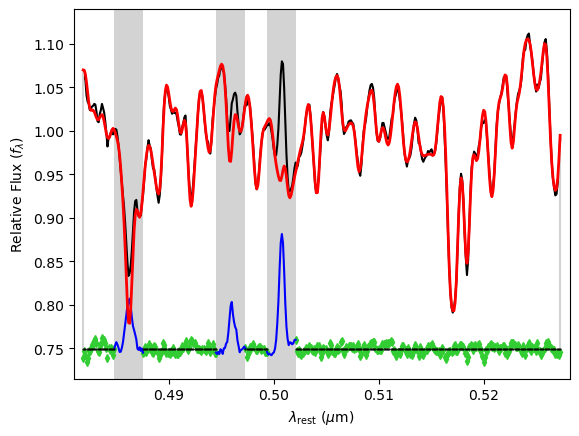

In [11]:
pp.plot()
plt.pause(5)